In [3]:
# General Python packages
import matplotlib.pyplot as plt
import numpy as np

# Ocean software packages
import dimod
from dwave.system import DWaveSampler, FixedEmbeddingComposite
from dwave.samplers import SimulatedAnnealingSampler

# Functions of this repository
from helpers.draw import draw_loop_comparison, draw_network, plot_ber_3d
from helpers.filters import apply_filters, compare_signals, create_filters, time_filter_instantiation
from helpers.general import loop_comparisons, obtain_QUBOmatrix, qci_solver, loop_comparisons_qci
from helpers.network import configure_network, create_channels, print_network_stats, simulate_signals

# Enable graphics inline
%matplotlib inline 

# Remove once dimod's mimo functions are updated
import warnings
warnings.filterwarnings('ignore')

# 1. Estructura 
## Creación de la red

Ratio Tx/Rx: 1.48.
La red tiene 129 transmisores y 87 receptores con 516 enlaces.


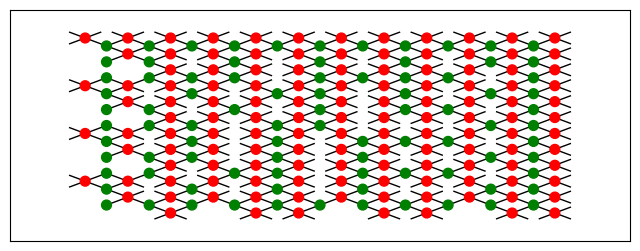

In [3]:
network, _ = configure_network(network_size=5)
print_network_stats(network)
draw_network(network)


## Canal

In [5]:
channels, channel_power = create_channels(network, F_distribution = ("binary", "real"))
print(f"Channels are represented by a {channels.shape[0]}x{channels.shape[1]} matrix.")

Channels are represented by a 87x129 matrix.


## Simulación de señales

In [10]:
y, transmitted_symbols = simulate_signals(channels, channel_power)                 
print(f"Primeros 10 símbolos transmitidos: {transmitted_symbols.flatten()[:10]}. \nPrimeros 10 símbolos distorsionados: {y.flatten()[:10]}.")

ValueError: BPSK transmitted signals must be real

## BQM

In [40]:
bqm = dimod.generators.wireless.coordinated_multipoint(network, 
                                                       modulation='QPSK',
                                                       transmitted_symbols=transmitted_symbols, 
                                                       F_distribution=('binary','real'), 
                                                       F=channels,
                                                       y=y)

print(f"BQM tiene {len(bqm)} variables con {len(bqm.quadratic)} términos cuadráticos.")

BQM tiene 258 variables con 784 términos cuadráticos.


In [42]:
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=10, num_sweeps=150)
_ = compare_signals(sampleset, transmitted_symbols)

ValueError: operands could not be broadcast together with shapes (258,) (129,) 

# 2. Evaluación de rendimiento

Ejecutando para SNRb = 2, ratio = 1
Tamaño de Q: 42436
2025-06-18 19:48:54 - Dirac allocation balance = 291 s
2025-06-18 19:48:55 - Job submitted: job_id='6852fc07b8b42e8edbee836f'
2025-06-18 19:48:55 - RUNNING
2025-06-18 19:49:38 - COMPLETED
2025-06-18 19:49:41 - Dirac allocation balance = 285 s
BER (%): 10.679611650485427
Ejecutando para SNRb = 2, ratio = 1.5
Tamaño de Q: 42436
2025-06-18 19:49:44 - Dirac allocation balance = 285 s
2025-06-18 19:49:44 - Job submitted: job_id='6852fc38b8b42e8edbee8370'
2025-06-18 19:49:44 - QUEUED
2025-06-18 19:49:47 - RUNNING
2025-06-18 19:50:28 - COMPLETED
2025-06-18 19:50:30 - Dirac allocation balance = 279 s
BER (%): 18.446601941747574
Ejecutando para SNRb = 2, ratio = 2
Tamaño de Q: 42436
2025-06-18 19:50:33 - Dirac allocation balance = 279 s
2025-06-18 19:50:34 - Job submitted: job_id='6852fc6ab8b42e8edbee8372'
2025-06-18 19:50:34 - QUEUED
2025-06-18 19:50:36 - RUNNING
2025-06-18 19:51:17 - COMPLETED
2025-06-18 19:51:20 - Dirac allocation balanc

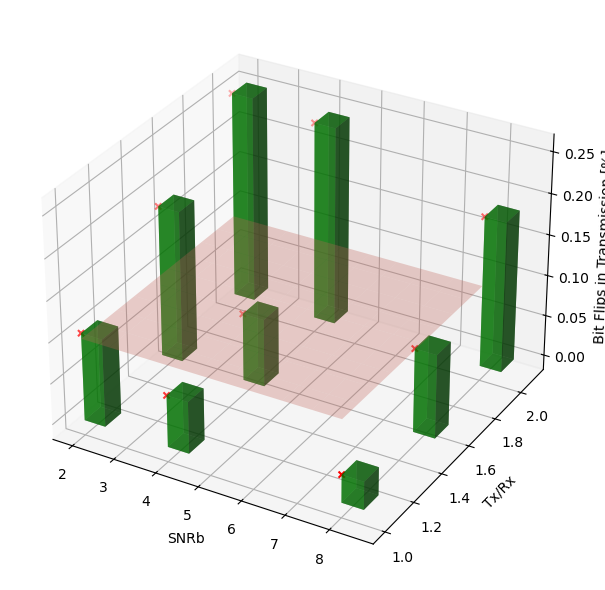

In [5]:
# Parámetros
network_size = 6
runs = 3
snrb_values = [2, 4, 8]
ratio_values = [1, 1.5, 2]


results = []

for i, SNRb in enumerate(snrb_values):
    for j, ratio in enumerate(ratio_values):
        print(f"Ejecutando para SNRb = {SNRb}, ratio = {ratio}")

        # Configurar red y canales
        network, _ = configure_network(network_size=network_size, ratio=ratio)
        channels, channel_power = create_channels(network)
        y, transmitted_symbols = simulate_signals(channels, channel_power, SNRb=SNRb)

        # Generar BQM
        bqm = dimod.generators.wireless.coordinated_multipoint(
            network,
            modulation='BPSK',
            transmitted_symbols=transmitted_symbols,
            F_distribution=('binary', 'real'),
            F=channels,
            y=y
        )
        Q = obtain_QUBOmatrix(bqm)
        print(f"Tamaño de Q: {Q.size}")

        # Resolver en QCI y almacenar resultados
        resultado = np.max(qci_solver(Q, runs, transmitted_symbols))
        # Resolver con simulated annealing

        BER = 100 - resultado  # Bit Error Rate

        print("BER (%):", BER)

        results.append([SNRb, ratio, BER])

# Convertir a array NumPy para análisis posterior
results = np.array(results)

plot_ber_3d(results, ber_threshold=10.0)

 # 3. Primer escenario: Condiciones Favorables

 Parámetros seleccionados:
 * SNRb = 10
 * Networksize = 5
 * Ratio Tx/Rx = 1.3

A continuación, se creará el entorno para dicho escenario. Modelando la red, el canal, las señales y el BQM.

In [3]:
SNRb = 10
ratio = 1.3
network_size = 5
network, _ = configure_network(network_size=network_size, ratio=ratio)

channels, channel_power =  create_channels(network)

y, transmitted_symbols = simulate_signals(channels, channel_power, SNRb=SNRb)  

bqm = dimod.generators.wireless.coordinated_multipoint(network, 
                                                       modulation='BPSK',
                                                       transmitted_symbols=transmitted_symbols, 
                                                       F_distribution=('binary','real'), 
                                                       F=channels,
                                                       y=y)

print(f"BQM tiene {len(bqm)} variables con {len(bqm.quadratic)} términos cuadráticos.")

BQM tiene 129 variables con 330 términos cuadráticos.


## Integración a QCI

Obtención de matriz QUBO y resultados accediendo al cloud device de QCI.

In [5]:
runs = 5

Q = obtain_QUBOmatrix(bqm)
print(Q.size)

results = qci_solver(Q,runs, transmitted_symbols)





16641
2025-06-18 18:54:51 - Dirac allocation balance = 275 s
2025-06-18 18:54:51 - Job submitted: job_id='6852ef5bb8b42e8edbee8354'
2025-06-18 18:54:51 - RUNNING
2025-06-18 18:56:02 - COMPLETED
2025-06-18 18:56:05 - Dirac allocation balance = 270 s


## Comparación de resultados

Se comparará en primer lugar con algoritmos clásicos y después con el filtro lineal Matched Filter

Ratio Tx/Rx: 1.28.
La red tiene 129 transmisores y 101 receptores con 516 enlaces.
Run number: 0, 1, 2, 3, 4, 



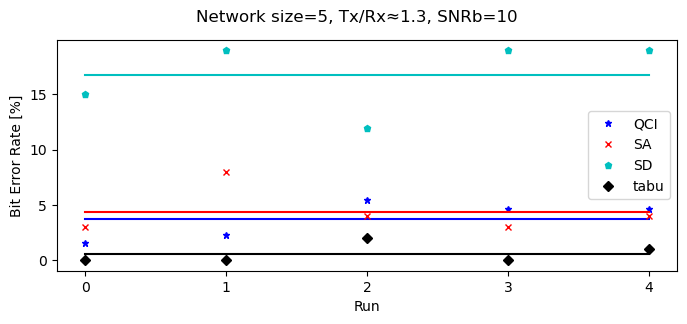

Ratio Tx/Rx: 1.26.
La red tiene 129 transmisores y 102 receptores con 516 enlaces.
Run number: 0, 1, 2, 3, 4, 



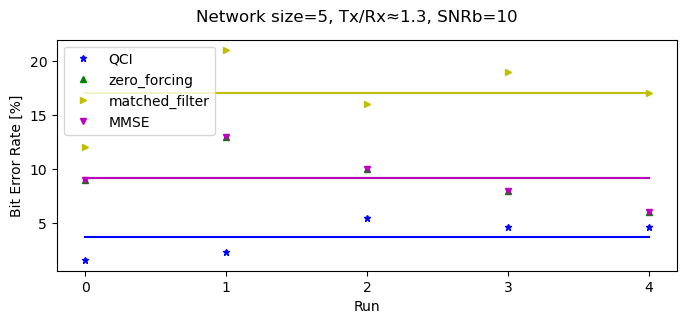

In [7]:
comparacion = loop_comparisons_qci(runs=5, network_size=network_size, snr=SNRb, ratio=ratio, solvers=['SA','SD', 'tabu'], qci_results=results)                                           
draw_loop_comparison(comparacion, network_size = network_size, ratio = ratio, SNRb = SNRb)

comparacion = loop_comparisons_qci(runs=5, network_size=network_size, snr=SNRb, ratio=ratio, qci_results=results)                                           
draw_loop_comparison(comparacion, network_size = network_size, ratio = ratio, SNRb = SNRb)

 # 4. Segundo escenario: Poblaciones densas

 Parámetros seleccionados:
 * SNRb = 5
 * Networksize = 16
 * Ratio Tx/Rx = 1.5

A continuación, se creará el entorno para dicho escenario. Modelando la red, el canal, las señales y el BQM.

In [13]:
SNRb = 5
ratio = 1.5
network_size = 16
network, _ = configure_network(network_size=network_size, ratio=ratio)

channels, channel_power =  create_channels(network)

y, transmitted_symbols = simulate_signals(channels, channel_power, SNRb=SNRb)  

bqm = dimod.generators.wireless.coordinated_multipoint(network, 
                                                       modulation='BPSK',
                                                       transmitted_symbols=transmitted_symbols, 
                                                       F_distribution=('binary','real'), 
                                                       F=channels,
                                                       y=y)

print(f"BQM has {len(bqm)} variables with {len(bqm.quadratic)} quadratic interactions.")

BQM has 1951 variables with 5300 quadratic interactions.


## Integración a QCI

Obtención de matriz QUBO y resultados accediendo al cloud device de QCI.

In [15]:
runs = 5


Q = obtain_QUBOmatrix(bqm)
print(Q.size)

#results = qci_solver(Q,runs,transmitted_symbols)

3806401


## Comparación de resultados

Se comparará en primer lugar con algoritmos clásicos y después con el filtro lineal Matched Filter

In [11]:

comparacion = loop_comparisons_qci(runs=5, network_size=network_size, snr=SNRb, ratio=ratio, solvers=['SA','SD', 'tabu'], qci_results=results)    
print(comparacion)
draw_loop_comparison(comparacion, network_size = network_size, ratio = ratio, SNRb = SNRb)

comparacion = loop_comparisons_qci(runs=5, network_size=network_size, snr=SNRb, ratio=ratio, solvers=['matched_filter'], qci_results=results)                                           
draw_loop_comparison(comparacion, network_size = network_size, ratio = ratio, SNRb = SNRb)

[83.46080305927343]


ValueError: Minimum supported runs is 3; got 1.